# Data Integration And Reshaping


## Importing necessary libraries

In [1]:
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup
from math import sin, cos, sqrt, atan2
import math
import cmath
from statistics import mean
from datetime import datetime
import zipfile
from IPython.display import display
from sklearn import preprocessing
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
#to display all rows without python automatically minimizing them with ... 


## Task 1

### Reading the Dataset

In [2]:
'''
reading main file
'''
data_frame = pd.read_csv('Group058.csv') #reading the given data frame Group058
print(data_frame.shape)
data_frame.head(5)

(720, 12)


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID539407125,6 Richardson Av,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429
1,ID156592057,3/915 Dandenong Rd,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690
2,ID987128967,67 Regent St,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800
3,ID616854389,42a Essex Rd,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160
4,ID241460161,74 Carpenter St,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840


- On inspecting the data frame, we can find a number of duplicate rows

- These rows are then dropped keeping the first row

### Removing Duplicate rows

In [3]:
data_frame = data_frame.drop_duplicates(subset=['ID','Date'], keep='first')
data_frame = data_frame.reset_index().drop(columns=['index'])
print(data_frame.shape)
data_frame.head(5)
#Deleting the 30 duplicated rows...Can be seen with the shape of the datat frame after deleting duplicate rows

(690, 12)


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID539407125,6 Richardson Av,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429
1,ID156592057,3/915 Dandenong Rd,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690
2,ID987128967,67 Regent St,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800
3,ID616854389,42a Essex Rd,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160
4,ID241460161,74 Carpenter St,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840


### Unzipping required files

* The necessary files are unzipped to extract necessary data to be integrated in the data set


In [4]:
'''
unzipping vic_suburb_boundary
'''
#unzipping the file using zipfile module
with zipfile.ZipFile('vic_suburb_boundary.zip','r') as zip_ref:
    zip_ref.extractall('./vic_suburb_boundary')

'''
unzipping gtfs
'''
#unzipping the files using zipfile module    
with zipfile.ZipFile('gtfs.zip','r') as zip_ref:
    zip_ref.extractall('./gtfs')

#Since there are a lot of folders inside, we use a for loop
for i in range(1,12):
    #Using try except because one of the folders is missing (9)
    try:
        file_name = './gtfs/' + str(i) + '/google_transit.zip'
        with zipfile.ZipFile(file_name,'r') as zip_ref:
            final_location = './gtfs/'+str(i)+'/google_transit/' 
            zip_ref.extractall(final_location)
    except FileNotFoundError:
        pass

In [5]:
'''
reading shape of suburbs
'''
#Using geopandas to read the shape file
shape_file = geopandas.read_file('vic_suburb_boundary')
shape_file.head(5)

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552399 -35.07228701, 141.74552..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.668767 -37.39571245, 148.6687620..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92287999 -37.97885997, 142.90449..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82335712 -37.66000897, 147.82312..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.279783 -35.99858911, 141.2798853..."


# Suburbs

To find the suburb in which houses lie, we create a point using the lattitude and longitude and see in what polygon it lies in . The polygons of each suburb is given in the vic_suburb_boundary.

In [6]:
'''
Creating default value for Suburb column as mentioned
'''

#inserting new column Suburb and filling all cells with not available (the default value)
data_frame.insert(loc=2,column='Suburb', value='not available')

In [7]:
#Iterating through each row in the given data frame
for i in range(len(data_frame)):
    #Getting the lattitude and longitude of the place
    lon = data_frame['Longtitude'][i]
    lat = data_frame['Lattitude'][i]
    #Creating a point from the given lattitude and longitude
    the_point = Point(lon, lat)
    #Iterating through the shape file
    for j in range(len(shape_file)):
        poly = shape_file['geometry'][j]
        #Creating polygons using the geometry column that contains the boundaries of the suburb
        poly = Polygon(poly)
        #Cheacking if the point is in the suburb and filling in cells
        if the_point.within(poly):
            data_frame['Suburb'][i] = shape_file['VIC_LOCA_2'][j]
            break   

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [8]:
#printing the top 5 rows
data_frame.head()

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840


# Crimes

* For crimes, we find the council in which each suburb lies. We then find the year from the date and add up all the crimes in that concil from the councils.txt and calculating the average.

In [9]:
#Creating a function that helps extract the suburb files from lines
#The suburbs are in single quotes
def get_subs(line):
    return re.findall("\'(.*?)\'", line)

* We create a dictionary where the key is the council and the value is a list of all the suburbs that lie in that council

In [10]:
'''
making a dictionary that contains council as key and the suburbs they contain as value
'''

#Reading the council file
council = open("councils.txt","r")

#Creating a empty dictionary
council_dict = {}

#Iterating through each line in the council
for line in council:
    #Substituting : and everything afterwards to none
    coun = re.sub(": .*", '', line)
    #Removing new line charecter
    coun = re.sub(' \n', '', coun)
    #Extrating suburb names from lines from the function we made earlier
    subs = get_subs(line)
    #Adding them to a dictionary
    council_dict[coun] = subs
    
council_dict

{'BANYULE': ['Abbotsford', 'Airport West', 'Albert Park', 'Alphington'],
 'BRIMBANK': ['Altona', 'Altona North', 'Armadale', 'Ascot Vale'],
 'DAREBIN': ['Ashburton', 'Ashwood', 'Avondale Heights', 'Balaclava'],
 'HOBSONS BAY': ['Balwyn', 'Balwyn North', 'Bentleigh', 'Bentleigh East'],
 'HUME': ['Box Hill', 'Braybrook', 'Brighton', 'Brighton East'],
 'MARIBYRNONG': ['Brunswick', 'Brunswick West', 'Bulleen', 'Burwood'],
 'MELBOURNE': ['Camberwell', 'Canterbury', 'Carlton North', 'Carnegie'],
 'MELTON': ['Caulfield', 'Caulfield North', 'Caulfield South', 'Chadstone'],
 'MOONEE VALLEY': ['Clifton Hill', 'Coburg', 'Coburg North', 'Collingwood'],
 'MORELAND': ['Doncaster', 'Eaglemont', 'Elsternwick', 'Elwood'],
 'NILLUMBIK': ['Essendon', 'Essendon North', 'Fairfield', 'Fitzroy'],
 'WHITTLESEA': ['Fitzroy North', 'Flemington', 'Footscray', 'Glen Iris'],
 'WYNDHAM': ['Glenroy', 'Gowanbrae', 'Hadfield', 'Hampton'],
 'YARRA': ['Hampton East',
  'Hawthorn',
  'Heidelberg Heights',
  'Heidelberg W

In [11]:
'''
making a column for council
'''

#Making new column for council for ease of calculating crimes and adding a default of "not available"
data_frame['council'] = 'not available'

In [12]:
'''
filling the row created above with the true value with the help of the dictionary created above
'''

#iteraing through each row in the given data frame (Group058)
for i in range(len(data_frame)):
    #Getting suburb from the suburb column we created above
    sub = data_frame['Suburb'][i]
    #Converting it into lower case for pattern matching
    sub = sub.lower()
    #Iterating through keys and values in the council dictionary
    for councils in council_dict:
        #Getting the suburbs for that council
        suburbs_in_council = council_dict[councils]
        #Lowering the string
        suburbs_in_council = str(suburbs_in_council).lower()
        #Checking if the suburb is there in that council to fill in the council column
        if sub in suburbs_in_council:
            data_frame['council'][i] = councils

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
'''
reading the crime excel sheet and transforming the data frame for easy access
'''

#Reading the crimebylocation excel sheet
crimes_excel = pd.read_excel('crimebylocationdatatable-yearending31march2016.xlsx', 'Table 1')
#Performing necessary cleaning
list_to_drop = range(0,18)
crimes_excel = crimes_excel.drop(list_to_drop)
crimes_excel = crimes_excel.drop(columns = ['Unnamed: 0'], axis = 1)
crimes_excel.columns = crimes_excel.iloc[0]
crimes_excel = crimes_excel.drop([18])
crimes_excel = crimes_excel.reset_index()
crimes_excel = crimes_excel.drop(columns = ['index'])
crimes_excel.head()

18,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


In [14]:
'''
setting default value as -1 for the three columns

creating required data frames for each column,
them grouping them based on the crime type and performing
arithemetic calculations to obtain mean
'''

#Creating 3 rows for crime average and filling them with -1 (default value)
data_frame.insert(loc=13,column='crime_A_average', value = float(-1))
data_frame.insert(loc=14,column='crime_B_average', value = float(-1))
data_frame.insert(loc=15,column='crime_C_average', value = float(-1))

#iterating through each row in the data frame
for i in range(len(data_frame)):
    #Extracting council for that row
    the_council = data_frame['council'][i]
    #Getting year from the date column
    year = int(data_frame['Date'][i][-4:])
    #Making a list of 3 previous years because we want the crimes only in the past 3 years
    list_of_years_req = [year - 1, year -2, year - 3]
    #Taking only those rows that come under the same council and are in the 3 year period
    req_df = crimes_excel[crimes_excel['Local Government Area'] == the_council]
    req_df = req_df[req_df['Apr - Mar reference period'].isin(list_of_years_req)]
    #Adding crimes and dividing by 3
    req_df = req_df.groupby(['CSA Offence Division']).sum()
    type_a_crimes = round(float(req_df['Offence Count'][0]/3),2)
    type_b_crimes = round(float(req_df['Offence Count'][1]/3),2)
    type_c_crimes = round(float(req_df['Offence Count'][2]/3),2)
    #Replacing the values by the calculated averages
    data_frame['crime_A_average'][i] = type_a_crimes
    data_frame['crime_B_average'][i] = type_b_crimes
    data_frame['crime_C_average'][i] = type_c_crimes
    
data_frame.head()

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,crime_A_average,crime_B_average,crime_C_average,council
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,1479.33,4398.67,502.00,GREATER BENDIGO
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,610.00,1743.67,228.00,BAW BAW
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,659.00,5219.33,338.33,BOROONDARA
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,2403.67,5212.33,586.67,LATROBE
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,2744.33,10289.67,780.00,HUME


# Primary school and secondary school

<h6>PRIMARY -</h6>For this, we initially scrape through the website. This helps us in finding the ranks of the top 500 primary schools. We then get the list of primary schools and their location from the schools.xml file. We then calculate the closest school using the formula below providing the lattitude and longitude of the houses and schools. We then get the rank from the information scraped from the site and if the school cannot be found in the information scraped, we make i as not ranked

In [15]:
'''
scraping contents of primary school
'''

#creating a function that returns the page source given url
def pgsource(url):
    primary_school_html = urlopen(url)
    bsObj = BeautifulSoup(primary_school_html, "html.parser")
    return bsObj

#Passing the url to the above function and getting the page source and converting it into a string
page_source  = pgsource('http://www.schoolcatchment.com.au/?p=12301')
page_source = str(page_source)

* The rankings are then extracted from the page source 

In [16]:
'''
ranking
'''

#Creating a function that extracts all ranks given the page source
def rankings(pgsource):
    return re.findall('<td class="column-1">(.*?)</td>', pgsource)

#storing all the ranks in a variable called ranks generated by passing the above page source to the function created
ranks = rankings(page_source)
    
ranks[0:5]

['1', '2', '3', '4', '5']

* The school names are extracted from the page source

In [17]:
'''
school name
'''

#Creating a function that extracts school names given page source
def schoolnames(pgsource):
    return re.findall('<td class="column-2">(.*?)</td>', pgsource)

#Extracting it by passing the above page source to the function created
school_names = schoolnames(page_source)

school_names[:5]

["Presbyterian Ladies' College",
 'Haileybury College',
 'Ballarat Clarendon College',
 'Fitzroy Community School',
 "Fintona Girls' School"]

* A data frame is then created for the school names and their rankings

In [18]:
'''
creating data frame
'''

#Creating a data frame using the ranks and school names extracted
rank_ps = pd.DataFrame(
{
    'rank' : ranks,
    'school_name': school_names
})

In [19]:
rank_ps

,rank,school_name
0,1,Presbyterian Ladies' College
1,2,Haileybury College
2,3,Ballarat Clarendon College
3,4,Fitzroy Community School
4,5,Fintona Girls' School
...,...,...
495,496,Holy Spirit School
496,497,Great Ryrie Primary School
497,498,St Justin's School
498,499,Wodonga Middle Years College


* The school.xml file is then read extract school names and school types 

In [20]:
#Reading the schools.xml file
school_data = open('schools.xml', 'r')

school_data

<_io.TextIOWrapper name='schools.xml' mode='r' encoding='cp1252'>

In [21]:
#Extracting information from schools.xml as text
school_data_as_text = ''

for lines in school_data:
    school_data_as_text = school_data_as_text + lines
    
#Converting &apos to '
school_data_as_text = re.sub('&apos;', "'", school_data_as_text)

In [22]:
#Extracting school names, X, Y and school type from schools.xml text
school_name = re.findall('<School_Name>(.*?)</School_Name>', school_data_as_text)
lon_of_school = re.findall('<X>(.*?)</X>', school_data_as_text)
lat_of_school = re.findall('<Y>(.*?)</Y>', school_data_as_text)
school_type = re.findall('<School_Type>(.*?)</School_Type>', school_data_as_text)

In [23]:
#Creating a data frame called school_info using this information
school_info = pd.DataFrame(
{
    'school_name':school_name,
    'school_type' : school_type,
    'longitude':lon_of_school,
    'lattitude':lat_of_school
})

school_info.head()

,school_name,school_type,longitude,lattitude
0,Alberton Primary School,Primary,146.666601,-38.617713
1,Allansford and District Primary School,Primary,142.590393,-38.386281
2,Avoca Primary School,Primary,143.475649,-37.084502
3,Avenel Primary School,Primary,145.234722,-36.901368
4,Warrandyte Primary School,Primary,145.21398,-37.742675


In [24]:
#Finding the unique values in school_type
school_info['school_type'].unique()

array(['Primary', 'Pri/Sec', 'Special', 'Secondary', 'Language'],
      dtype=object)

In [25]:
#Creating seperate data frames for the required school types
only_primary_schools = school_info[school_info['school_type'] == 'Primary']
only_secondary_schools = school_info[school_info['school_type'] == 'Secondary']
both_primary_secondary = school_info[school_info['school_type'] == 'Pri/Sec']

In [26]:
#Printing shapes to check
only_primary_schools.shape, only_secondary_schools.shape, both_primary_secondary.shape

((1556, 4), (343, 4), (243, 4))

In [27]:
#Adding primary/secondary types to only primary and only secondary schools
only_primary_schools = only_primary_schools.append(both_primary_secondary)
only_secondary_schools = only_secondary_schools.append(both_primary_secondary)
only_primary_schools = only_primary_schools.reset_index()
only_secondary_schools = only_secondary_schools.reset_index()

In [28]:
#printing size to check if appended properly
only_primary_schools.shape, only_secondary_schools.shape

((1799, 5), (586, 5))

### Finding Closest Primary and its Distance

* Calculating the distance to schools and taking the min distance and finding closest school and the distance. Finding the rank of the school using the information scraped from the website.

* Since the best rank is required and the ranks are sorted, we exit the loop as soon as we find a match while marking the ranks of the schools. This not only ensures efficiency optimisation but also ensures we get the best rank for the school.

In [29]:
'''
closest Primary school and the distance 
'''
#Radius of earth given
R = 6378

#Creating new columns for closest primary school and distance and filling them with the required default values
data_frame.insert(loc=16,column='closest_primary_school', value = 'not available')
data_frame.insert(loc=17,column='distance_to_closest_primary', value = float(-1))

#Iterating through each row in the data frame
for i in range(len(data_frame)):
    #assigning initial value for shortest distance and closest school
    shortest_distance = ''
    closest_school = ''
    #extracting lattitutde and longitude for each row
    lat1 = data_frame['Lattitude'][i]
    lon1 = data_frame['Longtitude'][i]
    for j in range(len(only_primary_schools)):
        #extracting lattitude and longitude of school
        lat2 = float(only_primary_schools['lattitude'][j])
        lon2 = float(only_primary_schools['longitude'][j])
        #Calculating difference
        dlat = math.radians(lat1 - lat2)
        dlon = math.radians(lon1 - lon2)
        #Calculating distance via formula
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = R * c
        #Substituting the first distance as string and further on replacing only if distance is smaller than previous distance
        if type(shortest_distance) == str:
            shortest_distance = distance
            closest_school = only_primary_schools['school_name'][j]
        else:
            if distance < shortest_distance:
                shortest_distance = distance
                closest_school = only_primary_schools['school_name'][j]
    #Multiplying by 1000
    shortest_distance = shortest_distance * 1000
    #Replacing value in closest primary school and distance by calculate values
    data_frame['closest_primary_school'][i] = closest_school
    data_frame['distance_to_closest_primary'][i] = shortest_distance

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Finding Primary School Ranking

* The Closest Primary School and Distance were integrated into the Dataset

* The Primary School Ranking is then integrated from rank_ps data set

In [30]:
#Creating a new column for primary school ranking and filling in values -1 as default
data_frame.insert(loc=18,column='primary_school_ranking', value = -1)

#Iterating through each row of the given data frame
for i in range(len(data_frame)):
    #Iterating through each row in the primary school data frame (created earlier)
    for j in range(len(rank_ps)):
        # If the schools match, filling cell value with the school rank and then breaking
        # Breaking to increase efficiency as well as append best rank
        if data_frame['closest_primary_school'][i] == rank_ps['school_name'][j]:
            data_frame['primary_school_ranking'][i] = rank_ps['rank'][j]
            #ensures first match to get the least rank
            break
    #If the schools not in the primary schools list, we replace cell value with not ranked
    if data_frame['primary_school_ranking'][i] == -1:
        data_frame['primary_school_ranking'][i] = 'not ranked'
        
data_frame.head()

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\JSSHR\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by I

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,council
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,GREATER BENDIGO
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,610.00,1743.67,228.00,St Mary's School,669.524015,159,BAW BAW
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,659.00,5219.33,338.33,St Raphael's School,642.162657,349,BOROONDARA
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,LATROBE
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,HUME


### Secondary

Since the website cannot be scraped because it requires monash authentication, we saved the page source of the website manually as secondary-school-ranking.html. We use this to find the location of schools. We then calculate distances to secondary schools and find the closest school and also find the distance using the formula that required the lattitude and longitude of school and the roperty and the radius of the Earth. We later sort the ranks in ascending order to ensure the best rank if found in the most efficient manner.

In [31]:
'''
page_source of file stored in html_file
'''

#We have downloaded the html file since it required monash authentication
html_file = open('secondary-school-ranking.html', 'r')

In [32]:
'''
converting the file into text
'''

#Creating a text that holds information of the secondary school ranking html
page_source = ''

for line in html_file:
    page_source = page_source + line

In [33]:
'''
extracting headings
'''

#Extracting headers to find what values signify what fields
heading = re.findall('<div style="display:none">\n(.*?)\n          </div>', page_source)
#Performing cleaning to obtain the headers alone
for i in range(len(heading)):
    heading[i] = heading[i].strip()
    heading[i] = re.sub(' ', '_', heading[i])
    
heading

['School_Name',
 'Ranking',
 'Change',
 'Median_VCE_study_score',
 '40+_study_scores']

In [34]:
#Creating a list of tuples that hold the values for school_name, Ranking, change, mediam_VCE_study_score and 40+_study_score
list_of_sec_data = re.findall('<li>\n<div>(.*?)</div>\n<div>(.*?)</div>\n<div>(.*?)</div>\n<div>(.*?)</div>\n<div>(.*?)</div>\n</li>', page_source)
list_of_sec_data

[('Academy of Mary Immaculate', '144', '-28', '31', '7.1%'),
 ('Adass Israel School', '534', '-1', 'N/A', 'N/A'),
 ('Advance College of Education', '535', '-1', 'N/A', 'N/A'),
 ('Aitken College', '194', '+32', '30', '4.8%'),
 ('Al Siraat College', '280', '+172', '28', '5.4%'),
 ('Al-Taqwa College', '400', '-37', '26', '3.8%'),
 ('Albert Park College', '131', '-42', '31', '8.6%'),
 ('Albury Wodonga Comm College', '536', '-1', 'N/A', 'N/A'),
 ('Alexandra Secondary College', '481', '+2', '24', '4.2%'),
 ('Alia College', '500', '-3', '24', '0%'),
 ('Alice Miller School', '127', '+126', '31', '9.6%'),
 ('Alkira Secondary College', '328', '+40', '28', '1.8%'),
 ('Alphington Grammar School', '86', '-1', '32', '12.1%'),
 ('Antonine College', '482', '-68', '24', '3.7%'),
 ('Apollo Bay P-12 College', '18', '+64', '36', '21.4%'),
 ('Aquinas College', '151', '+26', '31', '6.5%'),
 ('Ararat Secondary College', '486', '-49', '24', '1.5%'),
 ('Ashwood High School', '241', '-1', '29', '3.9%'),
 ('Assu

In [35]:
#Extrating only school name and their rank from the above list of tuples
list_of_sec_schools = []
sec_school_ranks = []

#Naming them as list_of_sec_schools and sec_school_ranks
for i in range(len(list_of_sec_data)):
    list_of_sec_data[i] = list(list_of_sec_data[i])
    list_of_sec_schools.append(list_of_sec_data[i][0])
    sec_school_ranks.append(list_of_sec_data[i][1])

In [36]:
#Creating a data frame that holds secondary school names and ranks
rank_ss = pd.DataFrame({
    'rank': sec_school_ranks,
    'school_name': list_of_sec_schools
})

#Arranging them in the order of increasing rank
rank_ss['rank'] = rank_ss['rank'].astype(int)
rank_ss = rank_ss.sort_values(by='rank')
rank_ss

,rank,school_name
54,1,Bialik College
318,2,Melbourne High School
227,3,Huntingtower School
289,4,Mac.Robertson Girls' High Schl
430,5,Ruyton Girls' School
...,...,...
561,580,Western Senior Sec Coll
565,581,William Angliss Inst of TAFE
568,582,Wodonga Institute of TAFE
574,583,Wyndham Community Centre


In [37]:
'''
closest Secondary school and the distance 
'''

#radius of earth given
R = 6378

#Creating a new column for closest secondary school and distance to sec school and filling them with the required default values
data_frame.insert(loc=19,column='closest_secondary_school', value = 'not available')
data_frame.insert(loc=20,column='distance_to_closest_secondary', value = float(-1))

#Iterating through each row in the given data frame
for i in range(len(data_frame)):
    #Assigning empty string to shortest distance and school
    shortest_distance = ''
    closest_school = ''
    #extracting lattitude and longitude information from each column
    lat1 = data_frame['Lattitude'][i]
    lon1 = data_frame['Longtitude'][i]
    #Iterating through all secondary schools
    for j in range(len(only_secondary_schools)):
        #Getting lattitude and longitude of schools
        lat2 = float(only_secondary_schools['lattitude'][j])
        lon2 = float(only_secondary_schools['longitude'][j])
        #Calculating the difference between the lattitude and longitudes
        dlat = math.radians(lat1 - lat2)
        dlon = math.radians(lon1 - lon2)
        #Calculating the differnece using the formula
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = R * c
        #Substituting the first calculated value as shortest distance and thereby replacing shortest distance if distance less than shortest distance
        if type(shortest_distance) == str:
            shortest_distance = distance
            closest_school = only_secondary_schools['school_name'][j]
        else:
            if distance < shortest_distance:
                shortest_distance = distance
                closest_school = only_secondary_schools['school_name'][j]
    #Multiplying with 1000 to convert kms to meters
    shortest_distance = shortest_distance * 1000
    #Replacing default values with the values calculated
    data_frame['closest_secondary_school'][i] = closest_school
    data_frame['distance_to_closest_secondary'][i] = shortest_distance
    
data_frame.head()

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,council
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,Sunbury Downs Secondary College,1302.189755,GREATER BENDIGO
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,610.00,1743.67,228.00,St Mary's School,669.524015,159,Oakwood School,1158.560548,BAW BAW
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,659.00,5219.33,338.33,St Raphael's School,642.162657,349,Preston High School,1471.580435,BOROONDARA
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,Siena College Ltd,855.042460,LATROBE
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,Brighton Grammar School,435.107227,HUME


In [38]:
#Creating a new column for secondary school ranking and adding -1 as default value
data_frame.insert(loc=21,column='secondary_school_ranking', value = -1)

#Iterating through each row in the data frame
for i in range(len(data_frame)):
    #Iterating through each school inforation
    for j in range(len(rank_ss)):
        #If the school names matches, changing the rank column with the appropriate rank
        if data_frame['closest_secondary_school'][i] == rank_ss['school_name'][j]:
            data_frame['secondary_school_ranking'][i] = rank_ss['rank'][j]
            #ensures first match to get the least rank (this also increases efficiency)
            break
    #If the school name isn't available, substituting -1 with not ranked
    if data_frame['secondary_school_ranking'][i] == -1:
        data_frame['secondary_school_ranking'][i] = 'not ranked'
        
data_frame.head()

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking,council
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,Sunbury Downs Secondary College,1302.189755,not ranked,GREATER BENDIGO
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,610.00,1743.67,228.00,St Mary's School,669.524015,159,Oakwood School,1158.560548,565,BAW BAW
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,659.00,5219.33,338.33,St Raphael's School,642.162657,349,Preston High School,1471.580435,not ranked,BOROONDARA
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,Siena College Ltd,855.042460,not ranked,LATROBE
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,Brighton Grammar School,435.107227,46,HUME


# Closest Train Station, distance , Travel time to CBD


* Each file is read for extracting data required to integrate into the Dataset

* The data is read only from the 1st two folders in the gtfs file since we only need train station ids

In [39]:
agency = pd.DataFrame()
dates = pd.DataFrame()
calendar = pd.DataFrame()
routes = pd.DataFrame()
shapes = pd.DataFrame()
stop_times = pd.DataFrame()
stops = pd.DataFrame()
trips = pd.DataFrame()

for i in range(1,3):
    try:
        agency_1 = pd.read_csv('./gtfs/'+str(i)+'/google_transit/agency.txt')
        agency = pd.concat([agency, agency_1], ignore_index = True)

        dates_1 = pd.read_csv('./gtfs/'+str(i)+'/google_transit/calendar_dates.txt')
        dates = pd.concat([dates, dates_1], ignore_index = True)

        calendar_1 = pd.read_csv('./gtfs/'+str(i)+'/google_transit/calendar.txt')
        calendar = pd.concat([calendar, calendar_1], ignore_index = True)

        routes_1 = pd.read_csv('./gtfs/'+str(i)+'/google_transit/routes.txt')
        routes = pd.concat([routes, routes_1], ignore_index = True)

        shapes_1 = pd.read_csv('./gtfs/'+str(i)+'/google_transit/shapes.txt')
        shapes = pd.concat([shapes, shapes_1], ignore_index = True)

        stop_times_1 = pd.read_csv('./gtfs/'+str(i)+'/google_transit/stop_times.txt')
        stop_times = pd.concat([stop_times, stop_times_1], ignore_index = True)

        stops_1 = pd.read_csv('./gtfs/'+str(i)+'/google_transit/stops.txt')
        stops = pd.concat([stops, stops_1], ignore_index = True)

        trips_1 = pd.read_csv('./gtfs/'+str(i)+'/google_transit/trips.txt')
        trips = pd.concat([trips, trips_1], ignore_index = True)
        
    except FileNotFoundError:
        pass
        

## Train Station ID and Distance

* All service id are extracted from the calendar and all rows containing these service id are filtered in trips dataset
* The trip ids from the trips data set is then extracted to find unique trip ids
* The stop times data set is then filtererd to contain only these trip ids and these trip ids are stored seperately
* The stop ids for southern cross station is extracted from stop data set
* The stop times is taken seperately and filtered to find all trip ids from all rows containing stop ids of Southern Cross Station
* The trip id previously stored is then filtered to contain trip_ids that go to southern cross station

In [40]:
service_id = list(set(calendar['service_id']))
#getting all service ids from calendar

trips1 = trips.loc[trips['service_id'].isin(service_id)]
#filtering trips to contain rows with these service ids

trips_id = list(set(trips1['trip_id']))
#finding unique trip ids

stop_times1 = stop_times.loc[stop_times['trip_id'].isin(trips_id)]
#filtering stop times to contain these unique trip ids

stopss = stops[stops['stop_name'].str.contains('Southern Cross Railway Station')]
southern_stop_id = list(set(stopss['stop_id']))
#finding the stop id for southern cross station

stop_times2 = stop_times1.loc[stop_times1['stop_id'].isin(southern_stop_id)]
#filtering the stop data set to contain stop_ids for stop names containg stop names

south_trip_id = stop_times2['trip_id']
#getting trip ids for trips going to southern cross station

stop_times3 = stop_times1.loc[stop_times1['trip_id'].isin(south_trip_id)]
stop_timess = stop_times3.reset_index(drop=True)
#filtering stop times to contain rows with trip_id that stop at southern cross station

fstop_id = stop_timess['stop_id']
#getting all stop ids

* Defining a function to find the distance between a pair of latittudes and longitudes

In [41]:
def distance(lat1, lon1, lat2, lon2):
    R = 6378
    lat1 = float(lat1)
    lon1 = float(lon1)
    lat2 = float(lat2)
    lon2 = float(lon2)
    
    dlat = math.radians(lat1 - lat2)
    dlon = math.radians(lon1 - lon2)
    
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    return(distance)
    

* Inserting two columns, train_station_id and distance to train station with default value -1

In [42]:
data_frame.insert(loc=13,column='train_station_id', value=float(-1))
data_frame.insert(loc=14,column='distance_to_train_station', value=float(-1))


* Finding the closest station to each suburb with trips that go straight to Southern Cross station based on the filtered stop id 

In [43]:

for i in range(len(data_frame)):
    shortest_distance = ''
    closest_station = ''
    lat1 = data_frame['Lattitude'][i]
    lon1 = data_frame['Longtitude'][i]
    #storing latitude and longitude for current row in each iteration
    for j in range(len(stops)):
        if stops['stop_id'][j] in fstop_id:
            lat2 = stops['stop_lat'][j]
            lon2 = stops['stop_lon'][j]
            #storing latitude and longitude for current row in each iteration
            dist = distance(lat1, lon1, lat2, lon2)
            #calculating distance for each pair of latittude and longitude
            
            if type(shortest_distance) == str:
                shortest_distance = dist
                closest_station = stops['stop_id'][j]
                #if shortest distance was not updated store current distance as shortest distance and get station id
            else:
                if dist < shortest_distance:
                    shortest_distance = dist
                    closest_station = stops['stop_id'][j]
                    #if current distance is less than shortest distance update shortest distance and get station id
                    
    shortest_distance = shortest_distance * 1000
    #multiplying by 1000 to get distance in meters
    data_frame['train_station_id'][i] = closest_station
    data_frame['distance_to_train_station'][i] = shortest_distance
    #updating the station id and distance columns in each row

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Travel Time to CBD

* The travel time to CBD is to be calculated for trains running on weeek days between 7 and 9:30 am for the calculated closest station have a direct trip to cbd

* In the below code we get service ids for train running on weekdays

In [44]:
service_id = []

for i in range(len(calendar['service_id'])):
#     if (calendar['monday'][i]==calendar['tuesday'][i]==calendar['wednesday'][i]==calendar['thursday'][i]==calendar['friday'][i]==1):
    if ((calendar['monday'][i] == 1) | (calendar['tuesday'][i] == 1) | (calendar['wednesday'][i] == 1) | (calendar['thursday'][i] == 1) | (calendar['friday'][i] == 1)) & (((calendar['saturday'][i] == 0)) & ((calendar['sunday'][i] == 0))):
        service_id.append(calendar['service_id'][i])
#getting service id for trains running on weekdays

service_id = list(set(service_id))

* Getting trips ids for services running on week days

In [45]:
trip_id = []

for i in range(len(trips)):
    if trips['service_id'][i] in service_id:
        trip_id.append(trips['trip_id'][i])     
#getting all trip ids for services running on week days

* getting stop ids for Southern cross station

In [46]:
stopss = stops[stops['stop_name'].str.contains('Southern Cross Railway Station')]
southern_stop_id = list(set(stopss['stop_id']))
#getting the stop ids for Southern Cross Station

* getting trip ids for these stop_ids

In [47]:
stop_trip_id = []

for i in range(len(stop_times)):
    if stop_times['stop_id'][i] in southern_stop_id:
        stop_trip_id.append(stop_times['trip_id'][i])
#getting trip ids for trains that stop at southern cross station


* getting the final filtered trip id for trains running on weekdays and trains stopping at souhtern cross station

In [48]:
req_trip_id = []

for id1 in stop_trip_id:
    if id1 in trip_id:
        req_trip_id.append(id1)
#fiiltering out trip ids for services runnning on weekdays and having a stop at southern cross

* getting all stop ids and trip ids for services running between 7 and 9:30 am

In [49]:
def strip_time(time):
    return(datetime.strptime(time,'%H:%M:%S'))

reqtrip_id = []
reqstop_id = []
c =0
start_time = strip_time('07:00:00')
end_time = strip_time('09:30:00')
#initialising start and stop times to 7am 9:30 am

for i in range(len(stop_times)):
    if stop_times['trip_id'][i] in req_trip_id:
        try:
            time =strip_time(stop_times['departure_time'][i])
            if start_time <= time <= end_time:
                reqtrip_id.append(stop_times['trip_id'][i])
                reqstop_id.append(stop_times['stop_id'][i])
                c+=1
        except:
            pass
        
reqstop_id = list(set(reqstop_id))

In [50]:
data_frame.insert(loc=15,column='travel_min_to_CBD', value = -1)
#inserting columns for travel_min_to_CBD with default value -1

* Filtering stop_times based on the give conditions

In [51]:
filtered_stop_times = stop_times[stop_times['trip_id'].isin(reqtrip_id)]
filtered_stop_times = filtered_stop_times[stop_times['stop_id'].isin(reqstop_id)].reset_index()
#

del filtered_stop_times['index']
t = 0
k= 0
for i in range(len(filtered_stop_times)):
    if filtered_stop_times['stop_id'][i] not in southern_stop_id:   
        try:
            time =strip_time(filtered_stop_times['departure_time'][i])

            if start_time <= time <= end_time:
                t+=1

            else:
                filtered_stop_times.drop(i, inplace = True)

        except:
            filtered_stop_times.drop(i, inplace = True)
            pass
# print(t,k)



C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [52]:
filtered_stop_times = filtered_stop_times.reset_index(drop=True)
filtered_stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,7548.UR.1-V08-A-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171
1,7548.UR.1-V08-A-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301
2,7548.UR.1-V08-A-mjp-1.1.H,07:45:00,07:45:00,20330,6,NaN,0,0,130530.089787
3,7548.UR.1-V08-A-mjp-1.1.H,07:57:00,07:57:00,20328,7,NaN,0,0,145000.117101
4,7548.UR.1-V08-A-mjp-1.1.H,08:16:00,08:16:00,20357,10,NaN,0,0,175519.536474
...,...,...,...,...,...,...,...,...,...
42800,1684.T0.2-WMN-F-mjp-1.4.R,09:09:00,09:09:00,19995,8,NaN,0,0,10620.456523
42801,1684.T0.2-WMN-F-mjp-1.4.R,09:11:00,09:11:00,19994,9,NaN,0,0,11980.942159
42802,1684.T0.2-WMN-F-mjp-1.4.R,09:13:00,09:13:00,19993,10,NaN,0,0,13683.496920
42803,1684.T0.2-WMN-F-mjp-1.4.R,09:15:00,09:15:00,19992,11,NaN,0,0,14579.681071


In [53]:
for i in range(len(data_frame)):
    dtime = []
    atime = []
    trip_id = []
    trips = []
    travel_min = []
    stop_id = data_frame['train_station_id'][i]
    d_stop_times = filtered_stop_times.loc[filtered_stop_times['stop_id']==stop_id]

    trip_id = d_stop_times['trip_id']
    dtime = d_stop_times['departure_time']
    dep = dict(zip(trip_id,dtime))
    a_stop_times = filtered_stop_times.loc[filtered_stop_times['stop_id'].isin(southern_stop_id)]
    a_stop_times = a_stop_times.loc[a_stop_times['trip_id'].isin(trip_id)]
    
    atime = a_stop_times['arrival_time']
    trips = a_stop_times['trip_id']
    #getting arrival times at southern cross station
    tup = list(zip(trips, dtime, atime))
    
    for j in range(len(tup)):
        a_time = tup[j][2].split(":")
        d_time = tup[j][1].split(":")
        a_time = int(a_time[0])*60 + int(a_time[1]) + int(a_time[2])/60
        d_time = int(d_time[0])*60 + int(d_time[1]) + int(d_time[2])/60
        #finding difference between arrival and departure time
        travel = abs(a_time-d_time)
        travel_min.append(travel)
#     print(travel_min)
    try:
        data_frame['travel_min_to_CBD'][i] = mean(travel_min)
    except:
        pass
#         print(travel_min)
        
        

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Overpriced

In [54]:
#Creating a column called over_priced? and filling values with -1
data_frame.insert(loc=16,column='over_priced?', value = -1)

#Creating a new column called year and filling values with 0 initially
data_frame['Year'] = 0
#Filling the year column with the year from the Date column 
for i in range(len(data_frame)):
    data_frame['Year'][i] = data_frame['Date'][i][-4:]

#Creating a new column called predicted price that holds the mediam value based on the rows rooms, type, bathroom, ssuburb, year
data_frame['predicted_price'] = data_frame.groupby(['Rooms', 'Type', 'Bathroom', 'Car', 'Suburb', 'Year'])['Price'].transform('median')

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
#Iterating through each row in the data frame
for i in range(len(data_frame)):
    #checking if the price is greater than predicted price
    if data_frame['Price'][i] > data_frame['predicted_price'][i]:
        #If greater, replace with True
        data_frame['over_priced?'][i] = True
    else:
        #If not, replace with false
        data_frame['over_priced?'][i] = False

C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\JSSHR\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
#Dropping unwanted columns
data_frame = data_frame.drop(columns=['council','Year','predicted_price'])
#printing the final version of th data frame
data_frame.head()

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,15351.0,2167.387035,45,False,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,Sunbury Downs Secondary College,1302.189755,not ranked
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,22248.0,393.618564,20,False,610.00,1743.67,228.00,St Mary's School,669.524015,159,Oakwood School,1158.560548,565
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,20011.0,465.382143,31,False,659.00,5219.33,338.33,St Raphael's School,642.162657,349,Preston High School,1471.580435,not ranked
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,19894.0,768.758732,25,False,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,Siena College Ltd,855.042460,not ranked
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,19951.0,414.505573,28,False,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,Brighton Grammar School,435.107227,46


In [57]:
data_frame.to_csv('Group058_solution.csv')

## Task 2

* Comparing different transformation for rooms, crime_C_average, travel_min_to_CBD, Age against

### 1. Standardisation

In [58]:
data_copy = data_frame.copy()

In [59]:
std_scale = preprocessing.StandardScaler().fit(data_copy[['Rooms','crime_C_average','travel_min_to_CBD','Age']])

data_std = std_scale.transform(data_copy[['Rooms', 'crime_C_average','travel_min_to_CBD','Age']])

data_std[0:5]

array([[ 1.09410828,  0.1795156 ,  1.94229358, -0.43098758],
       [-0.98560167, -0.52220655, -0.31512215,  0.37456031],
       [ 0.0542533 , -0.23964813,  0.67814077,  0.37456031],
       [ 1.09410828,  0.39635799,  0.136361  , -0.2967296 ],
       [ 2.13396326,  0.89148187,  0.40725088, -1.1022775 ]])

In [60]:
data_copy['Rooms_scaled'] = data_std[:,0]
data_copy['crime_C_average_scaled'] = data_std[:,1]
data_copy['travel_min_to_CBD_scaled'] = data_std[:,2]
data_copy['Age_scaled'] = data_std[:,3]
data_copy.head()

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking,Rooms_scaled,crime_C_average_scaled,travel_min_to_CBD_scaled,Age_scaled
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,15351.0,2167.387035,45,False,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,Sunbury Downs Secondary College,1302.189755,not ranked,1.094108,0.179516,1.942294,-0.430988
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,22248.0,393.618564,20,False,610.00,1743.67,228.00,St Mary's School,669.524015,159,Oakwood School,1158.560548,565,-0.985602,-0.522207,-0.315122,0.374560
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,20011.0,465.382143,31,False,659.00,5219.33,338.33,St Raphael's School,642.162657,349,Preston High School,1471.580435,not ranked,0.054253,-0.239648,0.678141,0.374560
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,19894.0,768.758732,25,False,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,Siena College Ltd,855.042460,not ranked,1.094108,0.396358,0.136361,-0.296730
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,19951.0,414.505573,28,False,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,Brighton Grammar School,435.107227,46,2.133963,0.891482,0.407251,-1.102277


In [61]:
data_copy.describe()

,Rooms,Price,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,crime_A_average,crime_B_average,crime_C_average,distance_to_closest_primary,distance_to_closest_secondary,Rooms_scaled,crime_C_average_scaled,travel_min_to_CBD_scaled,Age_scaled
count,690.000000,6.900000e+02,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,6.900000e+02,6.900000e+02,6.900000e+02,6.900000e+02
mean,2.947826,1.106626e+06,1.563768,1.571014,641.956522,55.050725,-37.805329,144.995412,20509.356522,1310.775122,23.489855,1158.462913,4821.655478,431.904913,564.165442,996.702542,1.599365e-16,-1.235726e-16,2.156085e-17,5.728107e-17
std,0.962370,6.710988e+05,0.722532,0.902360,3287.116198,37.268749,0.072296,0.099316,3329.172309,1056.370227,11.082644,873.474140,3982.915659,390.751194,299.926608,542.473629,1.000725e+00,1.000725e+00,1.000725e+00,1.000725e+00
min,1.000000,2.700000e+05,0.000000,0.000000,0.000000,2.000000,-38.161850,144.578940,15351.000000,103.815616,-1.000000,5.000000,68.000000,1.000000,37.173957,63.260422,-2.025457e+00,-1.103560e+00,-2.211351e+00,-1.424497e+00
25%,2.000000,6.665000e+05,1.000000,1.000000,161.250000,21.000000,-37.852400,144.938447,19920.000000,563.044320,15.000000,580.580000,1502.000000,159.330000,340.668776,595.062492,-9.856017e-01,-6.980725e-01,-7.666053e-01,-9.143163e-01
50%,3.000000,9.275000e+05,1.000000,2.000000,413.500000,49.000000,-37.801450,144.998395,19964.000000,960.936790,23.000000,959.000000,4701.330000,336.665000,535.490737,893.371577,5.425330e-02,-2.439122e-01,-4.423226e-02,-1.624716e-01
75%,3.000000,1.348250e+06,2.000000,2.000000,650.000000,79.000000,-37.758405,145.053350,20020.000000,1709.357709,31.000000,1540.670000,6845.670000,586.670000,735.431624,1315.579063,5.425330e-02,3.963580e-01,6.781408e-01,6.430763e-01
max,7.000000,5.525000e+06,5.000000,6.000000,75100.000000,162.000000,-37.568570,145.286880,52159.000000,5785.811850,70.000000,3767.670000,18944.000000,2042.330000,1736.187606,3322.182259,4.213673e+00,4.124347e+00,4.199709e+00,2.871759e+00


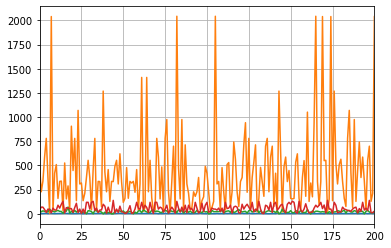

In [62]:
#before normalisation
data_copy['Rooms'].plot().set_xlim(0, 200), data_copy['crime_C_average'].plot().set_xlim(0, 200), data_copy['travel_min_to_CBD'].plot().set_xlim(0, 200),data_copy['Age'].plot().set_xlim(0, 200)
plt.grid(True)

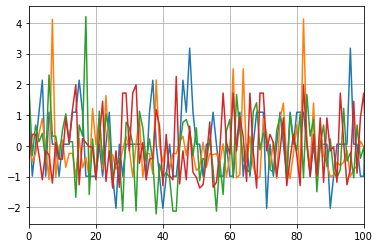

In [63]:
# before normalization
data_copy['Rooms_scaled'].plot().set_xlim(0, 100), data_copy['crime_C_average_scaled'].plot().set_xlim(0, 100), data_copy['travel_min_to_CBD_scaled'].plot().set_xlim(0, 100),data_copy['Age_scaled'].plot().set_xlim(0, 100)
plt.grid(True)

* On comparing the above to graphs the orginal and standardized are in a same shape and shifted

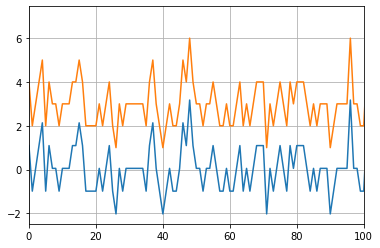

In [64]:
data_copy['Rooms_scaled'].plot().set_xlim(0, 100),data_copy['Rooms'].plot().set_xlim(0, 100)
plt.grid(True)

In [65]:
data_copy1 = data_frame.copy()

### 2. Min-Max Normalization

In [66]:
minmax_scale = preprocessing.MinMaxScaler().fit(data_copy1[['Rooms', 'crime_C_average','travel_min_to_CBD','Age']])
data_minmax = minmax_scale.transform(data_copy1[['Rooms', 'crime_C_average','travel_min_to_CBD','Age']])
data_minmax[0:5]

array([[0.5       , 0.24542823, 0.64788732, 0.23125   ],
       [0.16666667, 0.11120201, 0.29577465, 0.41875   ],
       [0.33333333, 0.16525011, 0.45070423, 0.41875   ],
       [0.5       , 0.28690609, 0.36619718, 0.2625    ],
       [0.66666667, 0.38161395, 0.4084507 , 0.075     ]])

In [67]:
minA = data_copy1.Rooms.min()
maxA = data_copy1.Rooms.max()
minA, maxA

(1, 7)

In [68]:
a = data_copy1.Rooms[0] 
mma = (a - minA) / (maxA - minA)
mma

0.5

In [69]:
data_minmax[0][0]

0.5

In [70]:
a = data_copy1[data_copy1.Rooms == data_copy1.Rooms.max()].Rooms
mma = (a - minA) / (maxA - minA)
mma

452    1.0
Name: Rooms, dtype: float64

In [71]:
print('Min-value after min-max scaling:\nRooms = {:.2f}, crime_C_average = {:.2f}, travel_min_to_CBD = {:.2f}, Age = {:.2f}'
      .format(data_minmax[:,0].min(), data_minmax[:,1].min(), data_minmax[:,2].min(), data_minmax[:,3].min()))
print('Max-value after min-max scaling:\nRooms = {:.2f}, crime_C_average = {:.2f}, travel_min_to_CBD = {:.2f}, Age = {:.2f}'      
      .format(data_minmax[:,0].max(), data_minmax[:,1].max(), data_minmax[:,2].max(), data_minmax[:,3].max()))

Min-value after min-max scaling:
Rooms = 0.00, crime_C_average = 0.00, travel_min_to_CBD = 0.00, Age = 0.00
Max-value after min-max scaling:
Rooms = 1.00, crime_C_average = 1.00, travel_min_to_CBD = 1.00, Age = 1.00


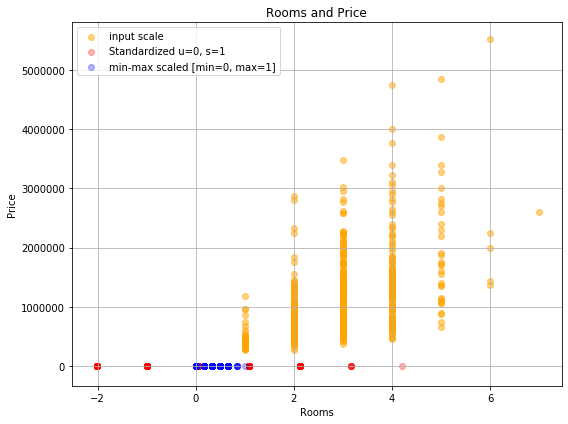

In [72]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(data_copy1['Rooms'], data_copy1['Price'],
            color='orange', label='input scale', alpha=0.5)

    plt.scatter(data_std[:,0], data_std[:,1], color='red',
             label='Standardized u=0, s=1', alpha=0.3)
    
    plt.scatter(data_minmax[:,0], data_minmax[:,1],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Rooms and Price')
    plt.xlabel('Rooms')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.grid(True)
plt.show()

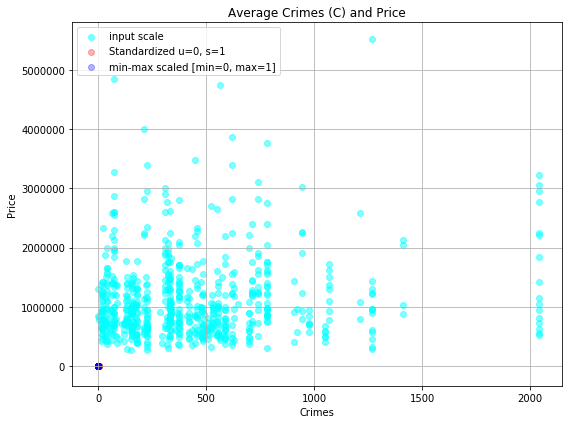

In [73]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(data_copy1['crime_C_average'], data_copy1['Price'],
            color='cyan', label='input scale', alpha=0.5)

    plt.scatter(data_std[:,0], data_std[:,1], color='red',
             label='Standardized u=0, s=1', alpha=0.3)
    
    plt.scatter(data_minmax[:,0], data_minmax[:,1],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Average Crimes (C) and Price')
    plt.xlabel('Crimes')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.grid(True)
plt.show()


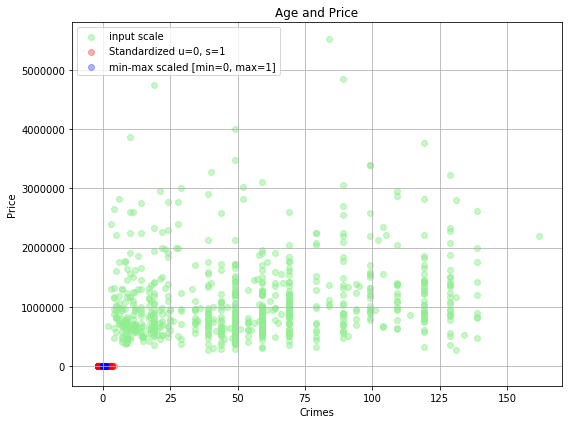

In [74]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(data_copy1['Age'], data_copy1['Price'],
            color='lightgreen', label='input scale', alpha=0.5)

    plt.scatter(data_std[:,0], data_std[:,1], color='red',
             label='Standardized u=0, s=1', alpha=0.3)
    
    plt.scatter(data_minmax[:,0], data_minmax[:,1],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Age and Price')
    plt.xlabel('Crimes')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.grid(True)
plt.show()


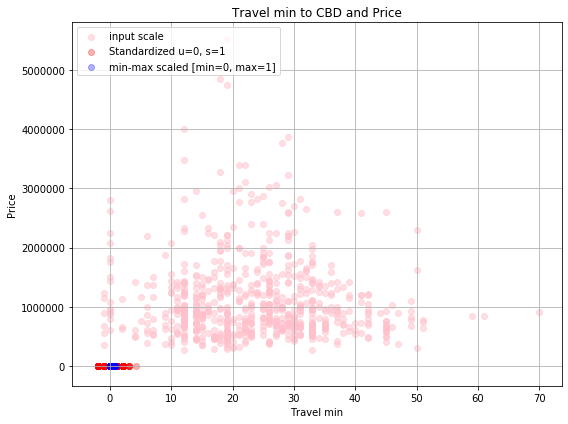

In [75]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(data_copy1['travel_min_to_CBD'], data_copy1['Price'],
            color='pink', label='input scale', alpha=0.5)

    plt.scatter(data_std[:,0], data_std[:,1], color='red',
             label='Standardized u=0, s=1', alpha=0.3)
    
    plt.scatter(data_minmax[:,0], data_minmax[:,1],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Travel min to CBD and Price')
    plt.xlabel('Travel min')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.grid(True)
plt.show()

* We can see that we get a bell curve for Travel min to CBD against price, we have a normal distribution
* Min-Max transformation works well for Travel min to CBD against price

### 3. Power Transformation

In [76]:
data_copy1['Price_power'] = data_copy1.apply(lambda data: math.pow(data['Price'],2), axis=1)
data_copy1['Rooms_power'] = data_copy1.apply(lambda data: math.pow(data['Rooms'],2), axis=1)
data_copy1['Crime_power'] = data_copy1.apply(lambda data: math.pow(data['crime_C_average'],2), axis=1)
data_copy1['Travel_power'] = data_copy1.apply(lambda data: math.pow(data['travel_min_to_CBD'],2), axis=1)
data_copy1['Age_power'] = data_copy1.apply(lambda data: math.pow(data['Age'],2), axis=1)
data_copy1.head()

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking,Price_power,Rooms_power,Crime_power,Travel_power,Age_power
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,15351.0,2167.387035,45,False,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,Sunbury Downs Secondary College,1302.189755,not ranked,3.600000e+11,16.0,252004.0000,2025.0,1521.0
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,22248.0,393.618564,20,False,610.00,1743.67,228.00,St Mary's School,669.524015,159,Oakwood School,1158.560548,565,2.500000e+11,4.0,51984.0000,400.0,4761.0
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,20011.0,465.382143,31,False,659.00,5219.33,338.33,St Raphael's School,642.162657,349,Preston High School,1471.580435,not ranked,7.656250e+11,9.0,114467.1889,961.0,4761.0
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,19894.0,768.758732,25,False,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,Siena College Ltd,855.042460,not ranked,2.975625e+12,16.0,344181.6889,625.0,1936.0
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,19951.0,414.505573,28,False,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,Brighton Grammar School,435.107227,46,7.562500e+12,25.0,608400.0000,784.0,196.0


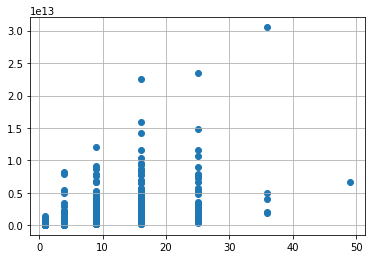

In [77]:
plt.scatter(data_copy1['Rooms_power'],data_copy1['Price_power'])
plt.grid(True)

* We can find a bell-shaped curve for Rooms vs price implying a normal distribution if outliers are removed
* Power transformation works well for these variables 

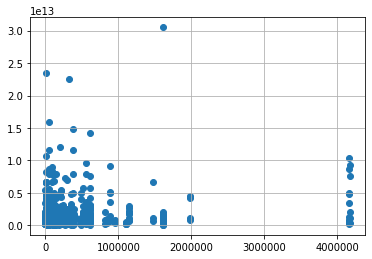

In [78]:
plt.scatter(data_copy1['Crime_power'],data_copy1['Price_power'])
plt.grid(True)

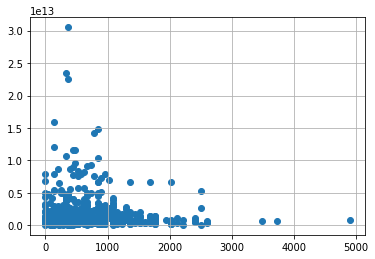

In [79]:
plt.scatter(data_copy1['Travel_power'],data_copy1['Price_power'])
plt.grid(True)

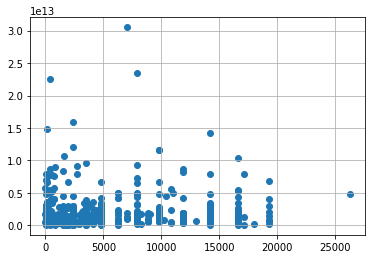

In [80]:
plt.scatter(data_copy1['Age_power'],data_copy1['Price_power'])
plt.grid(True)

### 4. Root Transformation

In [81]:
data_copy2 = data_frame.copy()

data_copy2 = data_frame.copy()
drop_index = data_copy2.loc[data_copy2['travel_min_to_CBD'].isin([-1,0])].index
list(drop_index)
data_copy2.drop(drop_index)

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,15351.0,2167.387035,45,False,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,Sunbury Downs Secondary College,1302.189755,not ranked
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,22248.0,393.618564,20,False,610.00,1743.67,228.00,St Mary's School,669.524015,159,Oakwood School,1158.560548,565
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,20011.0,465.382143,31,False,659.00,5219.33,338.33,St Raphael's School,642.162657,349,Preston High School,1471.580435,not ranked
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,19894.0,768.758732,25,False,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,Siena College Ltd,855.042460,not ranked
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,19951.0,414.505573,28,False,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,Brighton Grammar School,435.107227,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,ID350368068,31 Milford St,NEWPORT,2,h,1030000.0,15/10/2016,1.0,2.0,470.0,89.0,-37.84710,144.87690,19994.0,764.755062,16,False,71.00,261.00,20.00,Newport Gardens Primary School,739.780089,411,Bayside P-12 College,1387.917156,243
686,ID126204532,1/23 Bondi Rd,BONBEACH,3,h,836000.0,3/06/2017,2.0,2.0,407.0,49.0,-38.06257,145.12260,19859.0,259.260639,59,False,5.00,73.00,1.00,Bonbeach Primary School,511.784634,368,Patterson River Secondary College,2561.701380,not ranked
687,ID272028521,25 Cedar Dr,MARIBYRNONG,3,h,870000.0,3/12/2016,2.0,2.0,392.0,4.0,-37.77400,144.87440,20022.0,2986.044927,15,False,610.00,1743.67,228.00,Avondale Primary School,1430.011304,326,Maribyrnong Secondary College,1363.862210,not ranked
688,ID818897278,61 Murray Rd,COBURG,2,h,550000.0,4/03/2017,1.0,1.0,0.0,129.0,-37.73580,144.98010,19964.0,1540.443486,23,False,1097.67,5916.00,553.33,Newlands Primary School,785.235307,not ranked,Coburg High School,842.906097,79


In [82]:
data_copy2['Price_root'] = data_copy2.apply(lambda data: cmath.sqrt(data['Price']), axis=1)
data_copy2['Rooms_root'] = data_copy2.apply(lambda data: cmath.sqrt(data['Rooms']), axis=1)
data_copy2['Crime_root'] = data_copy2.apply(lambda data: cmath.sqrt(data['crime_C_average']), axis=1)
data_copy2['Travel_root'] = data_copy2.apply(lambda data: cmath.sqrt(data['travel_min_to_CBD']), axis=1)
data_copy2['Age_root'] = data_copy2.apply(lambda data: cmath.sqrt(data['Age']), axis=1)
data_copy2.head()

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking,Price_root,Rooms_root,Crime_root,Travel_root,Age_root
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,15351.0,2167.387035,45,False,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,Sunbury Downs Secondary College,1302.189755,not ranked,774.596669+0.000000j,2.000000+0.000000j,22.405357+0.000000j,6.708204+0.000000j,6.244998+0.000000j
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,22248.0,393.618564,20,False,610.00,1743.67,228.00,St Mary's School,669.524015,159,Oakwood School,1158.560548,565,707.106781+0.000000j,1.414214+0.000000j,15.099669+0.000000j,4.472136+0.000000j,8.306624+0.000000j
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,20011.0,465.382143,31,False,659.00,5219.33,338.33,St Raphael's School,642.162657,349,Preston High School,1471.580435,not ranked,935.414347+0.000000j,1.732051+0.000000j,18.393749+0.000000j,5.567764+0.000000j,8.306624+0.000000j
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,19894.0,768.758732,25,False,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,Siena College Ltd,855.042460,not ranked,1313.392554+0.000000j,2.000000+0.000000j,24.221272+0.000000j,5.000000+0.000000j,6.633250+0.000000j
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,19951.0,414.505573,28,False,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,Brighton Grammar School,435.107227,46,1658.312395+0.000000j,2.236068+0.000000j,27.928480+0.000000j,5.291503+0.000000j,3.741657+0.000000j


C:\Users\JSSHR\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


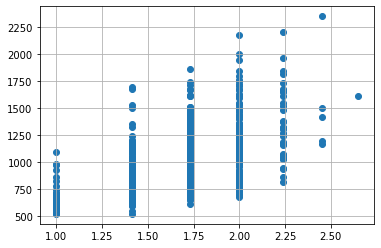

In [83]:
plt.scatter(data_copy2['Rooms_root'],data_copy2['Price_root'])
plt.grid(True)

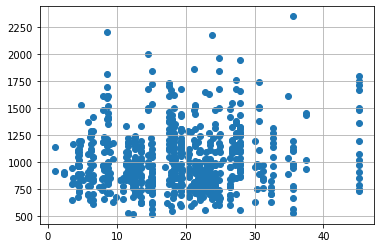

In [84]:
plt.scatter(data_copy2['Crime_root'],data_copy2['Price_root'])
plt.grid(True)

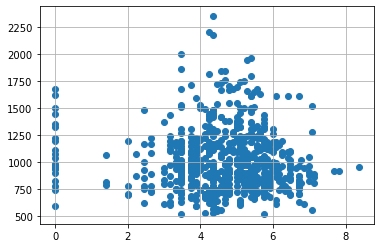

In [85]:
plt.scatter(data_copy2['Travel_root'],data_copy2['Price_root'])
plt.grid(True)

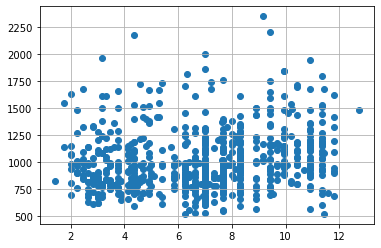

In [86]:
plt.scatter(data_copy2['Age_root'],data_copy2['Price_root'])
plt.grid(True)

### 5. Log Transformation

In [87]:
data_copy3 = data_frame.copy()
drop_index = data_copy3.loc[data_copy3['travel_min_to_CBD'].isin([-1,0])].index
list(drop_index)
data_copy3.drop(drop_index)

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,15351.0,2167.387035,45,False,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,Sunbury Downs Secondary College,1302.189755,not ranked
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,22248.0,393.618564,20,False,610.00,1743.67,228.00,St Mary's School,669.524015,159,Oakwood School,1158.560548,565
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,20011.0,465.382143,31,False,659.00,5219.33,338.33,St Raphael's School,642.162657,349,Preston High School,1471.580435,not ranked
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,19894.0,768.758732,25,False,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,Siena College Ltd,855.042460,not ranked
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,19951.0,414.505573,28,False,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,Brighton Grammar School,435.107227,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,ID350368068,31 Milford St,NEWPORT,2,h,1030000.0,15/10/2016,1.0,2.0,470.0,89.0,-37.84710,144.87690,19994.0,764.755062,16,False,71.00,261.00,20.00,Newport Gardens Primary School,739.780089,411,Bayside P-12 College,1387.917156,243
686,ID126204532,1/23 Bondi Rd,BONBEACH,3,h,836000.0,3/06/2017,2.0,2.0,407.0,49.0,-38.06257,145.12260,19859.0,259.260639,59,False,5.00,73.00,1.00,Bonbeach Primary School,511.784634,368,Patterson River Secondary College,2561.701380,not ranked
687,ID272028521,25 Cedar Dr,MARIBYRNONG,3,h,870000.0,3/12/2016,2.0,2.0,392.0,4.0,-37.77400,144.87440,20022.0,2986.044927,15,False,610.00,1743.67,228.00,Avondale Primary School,1430.011304,326,Maribyrnong Secondary College,1363.862210,not ranked
688,ID818897278,61 Murray Rd,COBURG,2,h,550000.0,4/03/2017,1.0,1.0,0.0,129.0,-37.73580,144.98010,19964.0,1540.443486,23,False,1097.67,5916.00,553.33,Newlands Primary School,785.235307,not ranked,Coburg High School,842.906097,79


In [88]:
data_copy3['Price_log'] = data_copy3.apply(lambda data: cmath.log(data['Price'] if data['Price'] else 1), axis=1)
data_copy3['Rooms_log'] = data_copy3.apply(lambda data: cmath.log(data['Rooms'] if data['Rooms'] else 1), axis=1)
data_copy3['Crime_log'] = data_copy3.apply(lambda data: cmath.log(data['crime_C_average'] if data['crime_C_average'] else 1), axis=1)
data_copy3['Travel_log'] = data_copy3.apply(lambda data: cmath.log(data['travel_min_to_CBD'] if data['travel_min_to_CBD'] else 1), axis=1)
data_copy3['Age_log'] = data_copy3.apply(lambda data: cmath.log(data['Age'] if data['Age'] else 1), axis=1)
data_copy3.head()


,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking,Price_log,Rooms_log,Crime_log,Travel_log,Age_log
0,ID539407125,6 Richardson Av,SUNBURY,4,h,600000.0,23/09/2017,2.0,1.0,1007.0,39.0,-37.57231,144.70429,15351.0,2167.387035,45,False,1479.33,4398.67,502.00,Sunbury West Primary School,810.407546,not ranked,Sunbury Downs Secondary College,1302.189755,not ranked,13.304685+0.000000j,1.386294+0.000000j,6.218600+0.000000j,3.806662+0.000000j,3.663562+0.000000j
1,ID156592057,3/915 Dandenong Rd,MALVERN EAST,2,t,500000.0,30/07/2016,1.0,1.0,50.0,69.0,-37.87670,145.04690,22248.0,393.618564,20,False,610.00,1743.67,228.00,St Mary's School,669.524015,159,Oakwood School,1158.560548,565,13.122363+0.000000j,0.693147+0.000000j,5.429346+0.000000j,2.995732+0.000000j,4.234107+0.000000j
2,ID987128967,67 Regent St,PRESTON,3,h,875000.0,28/08/2016,2.0,1.0,650.0,69.0,-37.73020,144.99800,20011.0,465.382143,31,False,659.00,5219.33,338.33,St Raphael's School,642.162657,349,Preston High School,1471.580435,not ranked,13.681979+0.000000j,1.098612+0.000000j,5.824022+0.000000j,3.433987+0.000000j,4.234107+0.000000j
3,ID616854389,42a Essex Rd,SURREY HILLS,4,h,1725000.0,18/06/2016,2.0,2.0,798.0,44.0,-37.83080,145.09160,19894.0,768.758732,25,False,2403.67,5212.33,586.67,Canterbury Primary School,743.681176,43,Siena College Ltd,855.042460,not ranked,14.360738+0.000000j,1.386294+0.000000j,6.374462+0.000000j,3.218876+0.000000j,3.784190+0.000000j
4,ID241460161,74 Carpenter St,BRIGHTON,5,h,2750000.0,7/05/2016,3.0,1.0,509.0,14.0,-37.91180,144.99840,19951.0,414.505573,28,False,2744.33,10289.67,780.00,Brighton Primary School,239.515663,342,Brighton Grammar School,435.107227,46,14.827111+0.000000j,1.609438+0.000000j,6.659294+0.000000j,3.332205+0.000000j,2.639057+0.000000j


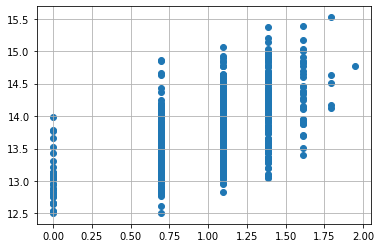

In [89]:
plt.scatter(data_copy3['Rooms_log'],data_copy3['Price_log'])
plt.grid(True)

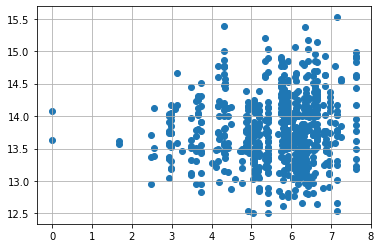

In [90]:
plt.scatter(data_copy3['Crime_log'],data_copy3['Price_log'])
plt.grid(True)

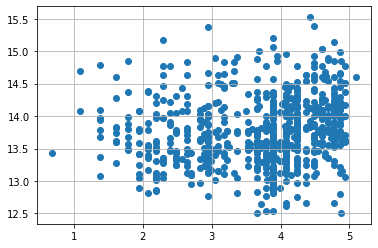

In [91]:
plt.scatter(data_copy3['Age_log'],data_copy3['Price_log'])
plt.grid(True)

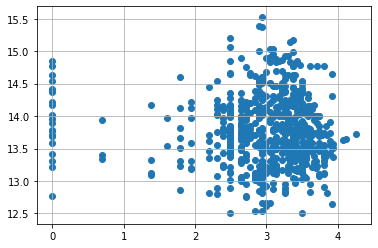

In [92]:
plt.scatter(data_copy3['Travel_log'],data_copy3['Price_log'])
plt.grid(True)

## Conclusion 



* To build the regression model, we have to remove outliers and carry out any prediction. The fewer the outliers in the model the more accurate the prediction will be.
* On investigating the different transformations, we suggest that log and root transformation will work well compared to the others as they narrow the value of property price. This may result in a more accurate prediction due to lesser outliers.
* The Distribution is more symmetric in log and sqrt transformations. We can imply that the regression models for these two transformations can predict a better result. 